In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [2]:
current_dir = os.getcwd() 
current_dir

'c:\\Maestria\\Trabajo de grado\\repositorio\\datalab'

In [3]:
# Import root module
current_dir = os.getcwd() # Obtener la ruta del directorio actual del notebook
ROOT_PATH = os.path.dirname(current_dir) # Obtener la ruta del directorio superior
sys.path.insert(1, ROOT_PATH) # Insertar la ruta en sys.path
import root

In [4]:
#creating paths from root 
fiscalia_path = root.DIR_DATA_STAGE + 'fiscalia.pkl'
girardota_path = root.DIR_DATA_STAGE + 'girardota.pkl'
itagui_path = root.DIR_DATA_STAGE + 'itagui.pkl'
trafico_path = root.DIR_DATA_STAGE + 'trafico.pkl'

In [5]:
from pandas import DataFrame
# Read datasets from local
fisc: DataFrame = pd.read_pickle(fiscalia_path)
gir: DataFrame = pd.read_pickle(girardota_path)
ita: DataFrame = pd.read_pickle(itagui_path)
traf: DataFrame = pd.read_pickle(trafico_path)

In [6]:
fisc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32137 entries, 2021-01-01 00:00:00 to 2024-09-01 00:00:00
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DViento_SSR   25396 non-null  float64
 1   HAire10_SSR   25375 non-null  float64
 2   PLiquida_SSR  25375 non-null  float64
 3   P_SSR         25375 non-null  float64
 4   TAire10_SSR   25375 non-null  float64
 5   VViento_SSR   25396 non-null  float64
 6   SO2           9881 non-null   float64
 7   Calidad_SO2   32137 non-null  float64
dtypes: float64(8)
memory usage: 2.2 MB


## Convertir 0 en nulos

In [7]:
fisc.replace(0, np.nan, inplace=True)
gir.replace(0, np.nan, inplace=True)
ita.replace(0, np.nan, inplace=True)
traf.replace(0, np.nan, inplace=True)

In [8]:
fisc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32137 entries, 2021-01-01 00:00:00 to 2024-09-01 00:00:00
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DViento_SSR   23457 non-null  float64
 1   HAire10_SSR   24816 non-null  float64
 2   PLiquida_SSR  4574 non-null   float64
 3   P_SSR         24846 non-null  float64
 4   TAire10_SSR   24840 non-null  float64
 5   VViento_SSR   23458 non-null  float64
 6   SO2           9881 non-null   float64
 7   Calidad_SO2   32137 non-null  float64
dtypes: float64(8)
memory usage: 2.2 MB


# Imputacion temporal para encontrar outliers

In [9]:
# Crear copias de los DataFrames
gir_imp = gir.copy()
ita_imp = ita.copy()
traf_imp = traf.copy()
fisc_imp = fisc.copy()

# Aplicar imputación sencilla (Media móvil de 3 períodos)
fisc_mean_imputed = fisc_imp.fillna(fisc_imp.rolling(window=3, min_periods=1).mean())
gir_mean_imputed = gir_imp.fillna(gir_imp.rolling(window=3, min_periods=1).mean())
ita_mean_imputed = ita_imp.fillna(ita_imp.rolling(window=3, min_periods=1).mean())
traf_mean_imputed = traf_imp.fillna(traf_imp.rolling(window=3, min_periods=1).mean())

# Aplicar imputación avanzada (Interpolación con método 'time')
fisc_interpolate_imputed = fisc_mean_imputed.interpolate(method='time')
gir_interpolate_imputed = gir_mean_imputed.interpolate(method='time')
ita_interpolate_imputed = ita_mean_imputed.interpolate(method='time')
traf_interpolate_imputed = traf_mean_imputed.interpolate(method='time')


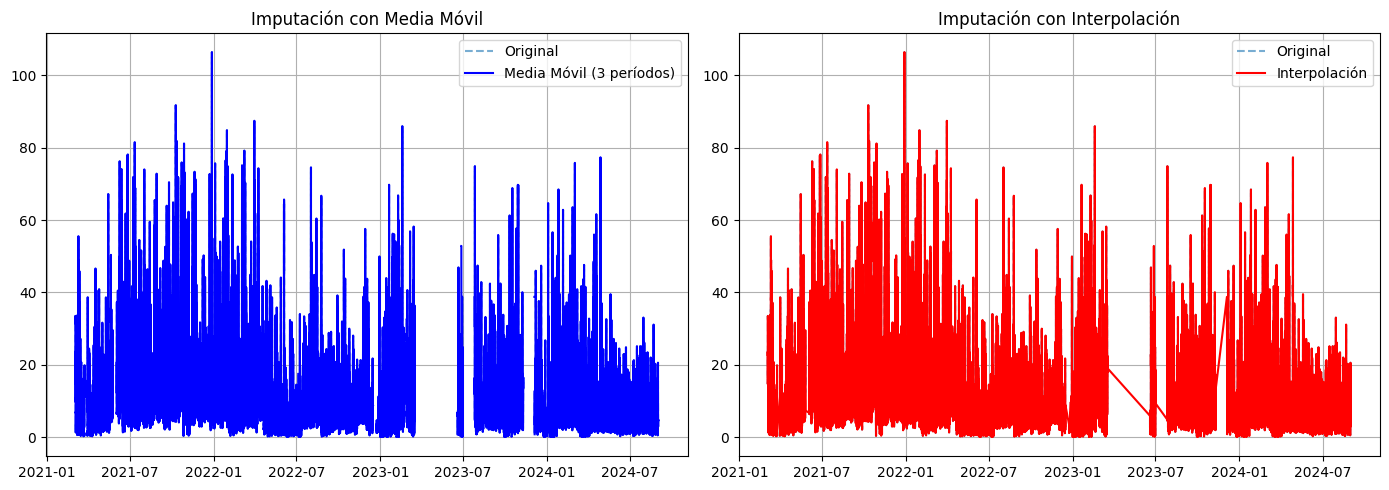

In [10]:
# Crear la figura y los subgráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Graficar la serie original con datos faltantes
axes[0].plot(traf['SO2'], label='Original', linestyle='dashed', alpha=0.6)
axes[0].plot(traf_mean_imputed['SO2'], label='Media Móvil (3 períodos)', color='blue')
axes[0].set_title("Imputación con Media Móvil")
axes[0].legend()
axes[0].grid()

# Graficar la serie interpolada
axes[1].plot(traf['SO2'], label='Original', linestyle='dashed', alpha=0.6)
axes[1].plot(traf_interpolate_imputed['SO2'], label='Interpolación', color='red')
axes[1].set_title("Imputación con Interpolación")
axes[1].legend()
axes[1].grid()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## Filtrar datasets con fechas donde hayan datos de clima y medicion del contaminante

In [11]:
df = traf.copy()

# Filtrar solo las columnas de interés para encontrar la primera fecha válida
first_valid_date = df[['SO2', 'TAire10_SSR']].dropna().index.min()

# Filtrar el DataFrame completo desde esa fecha en adelante
df_filtered = df[df.index >= first_valid_date]

print("Primera fecha con datos en SO2 y TAire10_SSR:", first_valid_date)

Primera fecha con datos en SO2 y TAire10_SSR: 2023-01-01 00:00:00


In [12]:
import pandas as pd

# Cargar los DataFrames
fisc_imp = fisc_interpolate_imputed
gir_imp = gir_interpolate_imputed
ita_imp = ita_interpolate_imputed
traf_imp = traf_interpolate_imputed
# Lista de DataFrames originales y nombres para referencia
dfs = {'fisc': fisc_imp, 'gir': gir_imp, 'ita': ita_imp, 'traf': traf_imp}

# Crear un diccionario para guardar los DataFrames filtrados
filtered_dfs = {}

for name, df in dfs.items():
    df_copy = df.copy()
    
    # Encontrar la primera fecha con datos en 'SO2' y 'TAire10_SSR'
    first_valid_date = df_copy[['SO2', 'TAire10_SSR']].dropna().index.min()
    
    # Filtrar el DataFrame completo desde esa fecha en adelante
    df_filtered = df_copy[df_copy.index >= first_valid_date]
    
    # Guardar el DataFrame filtrado en el diccionario
    filtered_dfs[name + '_filtered'] = df_filtered
    
    # Imprimir la primera fecha válida para referencia
    print(f"Primera fecha con datos en {name}: {first_valid_date}")

Primera fecha con datos en fisc: 2023-02-24 12:00:00
Primera fecha con datos en gir: 2023-01-01 00:00:00
Primera fecha con datos en ita: 2023-05-12 23:00:00
Primera fecha con datos en traf: 2023-01-01 00:00:00


In [13]:
traf_imp.columns

Index(['DViento_SSR', 'HAire10_SSR', 'PLiquida_SSR', 'P_SSR', 'TAire10_SSR',
       'VViento_SSR', 'SO2', 'Calidad_SO2'],
      dtype='object', name=0)

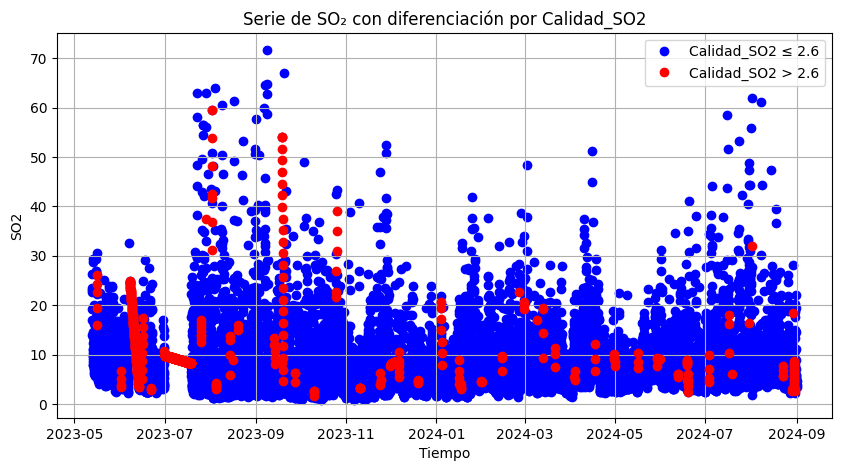

In [14]:
import matplotlib.pyplot as plt

df = ita_imp

# Filtramos los datos según la condición
condicion = df["Calidad_SO2"] > 2.6

# Creamos la figura y los ejes
plt.figure(figsize=(10, 5))

# Graficamos primero los puntos con Calidad_SO2 ≤ 2.6 (para que queden debajo)
plt.plot(df.index[~condicion], df["SO2"][~condicion], 'bo', label="Calidad_SO2 ≤ 2.6", zorder=1)  # Azul

# Luego graficamos los puntos con Calidad_SO2 > 2.6 (para que queden encima)
plt.plot(df.index[condicion], df["SO2"][condicion], 'ro', label="Calidad_SO2 > 2.6", zorder=2)  # Rojo

# Configuraciones del gráfico
plt.xlabel("Tiempo")
plt.ylabel("SO2")
plt.title("Serie de SO₂ con diferenciación por Calidad_SO2")
plt.legend()
plt.grid()

# Mostrar gráfico
plt.show()



In [15]:
fisc_filt = filtered_dfs['fisc_filtered']
gir_filt = filtered_dfs['gir_filtered']
ita_filt = filtered_dfs['ita_filtered']
traf_filt = filtered_dfs['traf_filtered']

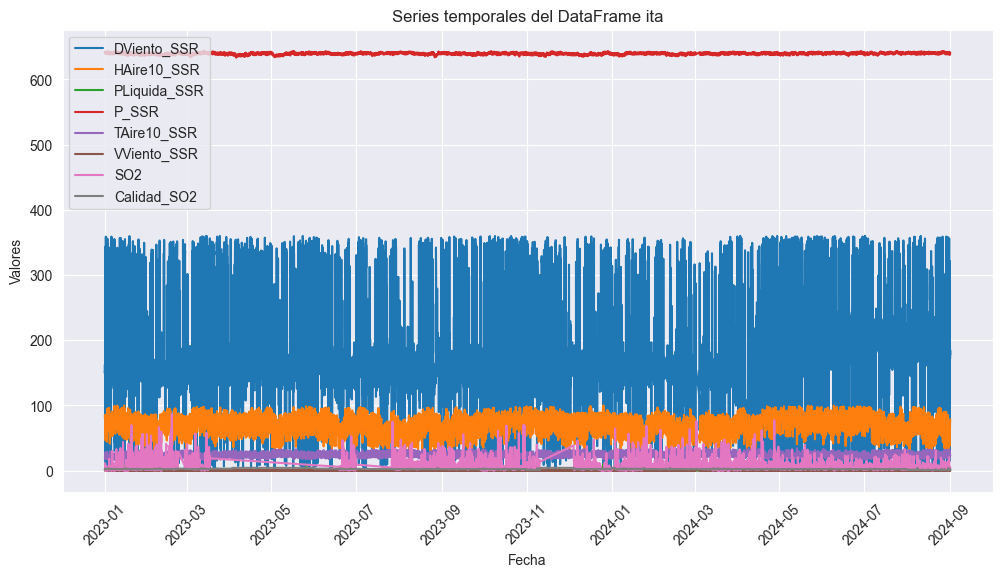

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_style("darkgrid")

# Graficar el DataFrame
plt.figure(figsize=(12, 6))
plt.plot(traf_filt.index, traf_filt, linewidth=1.5)

# Etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.title("Series temporales del DataFrame ita")

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Mostrar la leyenda (usando nombres de columnas)
plt.legend(traf_filt.columns, loc="upper left")

# Mostrar la gráfica
plt.show()

## Identificar outliers

In [17]:
df = traf.copy()

### Univariables (Solo serie de SO2)

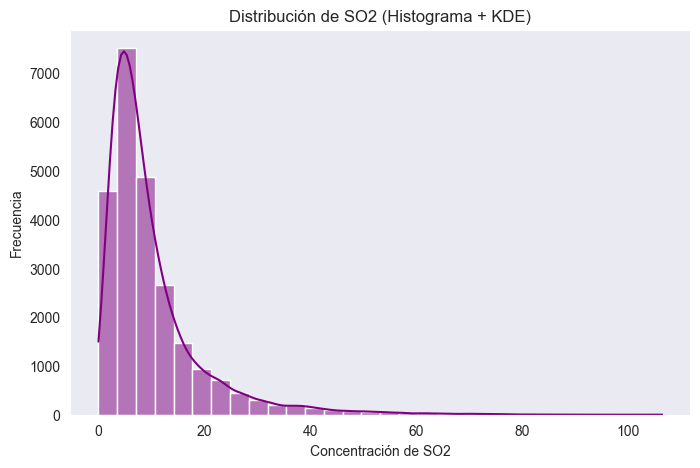

In [18]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['SO2'].dropna(), bins=30, kde=True, color='purple')
plt.xlabel("Concentración de SO2")
plt.ylabel("Frecuencia")
plt.title("Distribución de SO2 (Histograma + KDE)")
plt.grid()
plt.show()


#### Metodo IQR

Total de outliers detectados en SO2: 1844


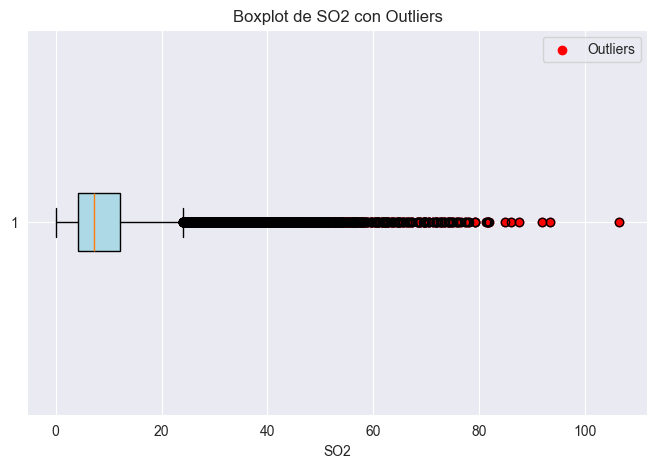

Nuevo DataFrame sin outliers en SO2: 30293 filas


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Q1 = df['SO2'].quantile(0.25)
Q3 = df['SO2'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers_SO2 = (df['SO2'] < lower_bound) | (df['SO2'] > upper_bound)


num_outliers_SO2 = outliers_SO2.sum()
print(f"Total de outliers detectados en SO2: {num_outliers_SO2}")


plt.figure(figsize=(8, 5))
plt.boxplot(df['SO2'].dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.scatter(df['SO2'][outliers_SO2], np.ones(sum(outliers_SO2)), color='red', label='Outliers')
plt.xlabel("SO2")
plt.title("Boxplot de SO2 con Outliers")
plt.legend()
plt.show()

# **Eliminar outliers y crear df limpio**
df_clean = df[~outliers_SO2].copy()  # Filtramos solo los valores sin outliers
print(f"Nuevo DataFrame sin outliers en SO2: {df_clean.shape[0]} filas")


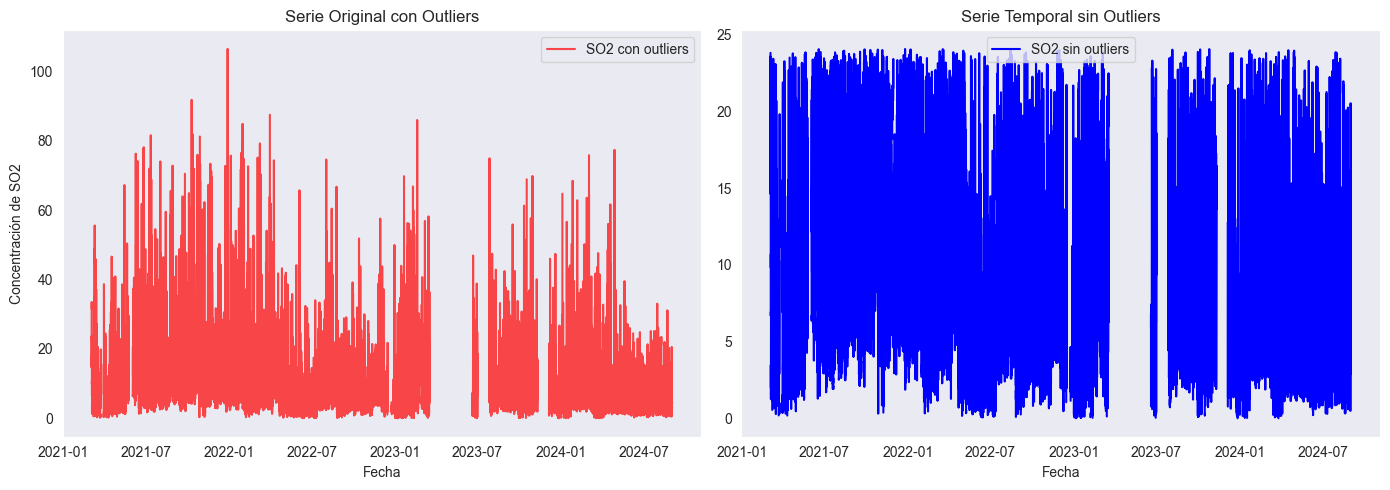

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Gráfico original con outliers
axes[0].plot(df.index, df['SO2'], label='SO2 con outliers', color='red', alpha=0.7)
axes[0].set_title("Serie Original con Outliers")
axes[0].set_xlabel("Fecha")
axes[0].set_ylabel("Concentración de SO2")
axes[0].legend()
axes[0].grid()

# Gráfico sin outliers
axes[1].plot(df_clean.index, df_clean['SO2'], label='SO2 sin outliers', color='blue')
axes[1].set_title("Serie Temporal sin Outliers")
axes[1].set_xlabel("Fecha")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


#### Metodo Local Outlier Factor 

In [21]:
from sklearn.neighbors import LocalOutlierFactor

# Aplicar LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)  
outlier_labels = lof.fit_predict(df[['SO2']].dropna())  # Solo usamos SO2 y eliminamos NaN temporalmente

# Crear un DataFrame auxiliar para recuperar los índices correctos
df_aux = df[['SO2']].dropna().copy()
df_aux['LOF_outlier'] = outlier_labels  # -1 son outliers, 1 son normales

# Identificar índices de los outliers
outliers_indices = df_aux[df_aux['LOF_outlier'] == -1].index.tolist()

print(f"Se identificaron {len(outliers_indices)} outliers con LOF.")


Se identificaron 245 outliers con LOF.


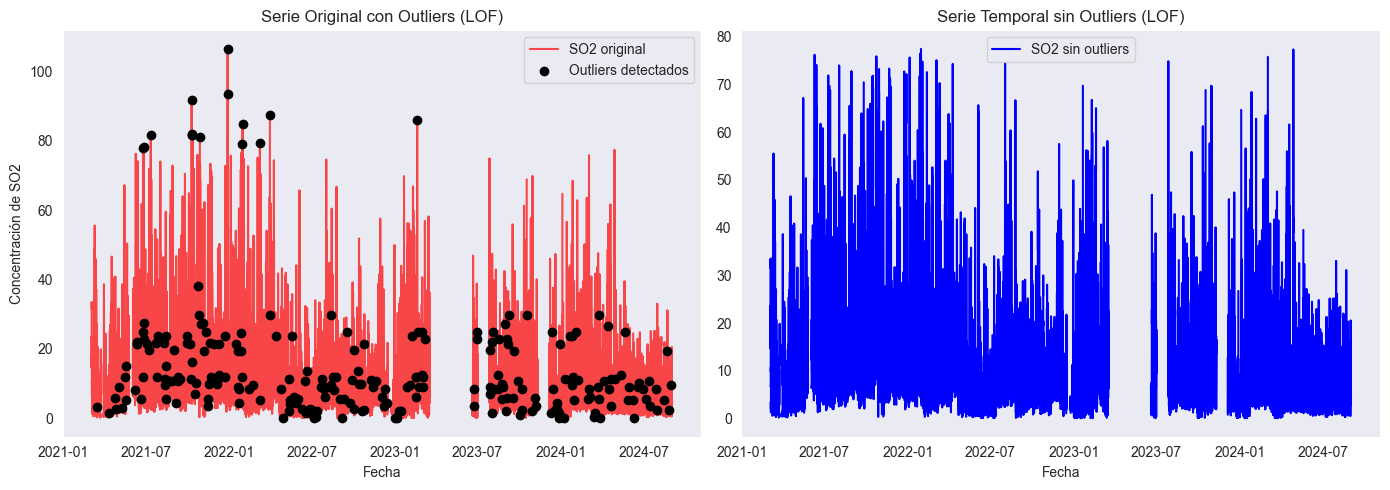

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Gráfico original con outliers resaltados
axes[0].plot(df.index, df['SO2'], label='SO2 original', color='red', alpha=0.7)
axes[0].scatter(df.loc[outliers_indices].index, df.loc[outliers_indices, 'SO2'], 
                color='black', marker='o', label='Outliers detectados', zorder=3)
axes[0].set_title("Serie Original con Outliers (LOF)")
axes[0].set_xlabel("Fecha")
axes[0].set_ylabel("Concentración de SO2")
axes[0].legend()
axes[0].grid()

# Gráfico sin outliers
df_clean_lof = df.copy()
df_clean_lof.loc[outliers_indices, 'SO2'] = np.nan  # Reemplazamos outliers con NaN (sin eliminarlos)
axes[1].plot(df_clean_lof.index, df_clean_lof['SO2'], label='SO2 sin outliers', color='blue')
axes[1].set_title("Serie Temporal sin Outliers (LOF)")
axes[1].set_xlabel("Fecha")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


#### Metodo isolation forest

In [23]:
from sklearn.ensemble import IsolationForest

# Aplicar Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_labels = iso_forest.fit_predict(df[['SO2']].dropna())  # Solo usamos SO2 y eliminamos NaN temporalmente

# Crear un DataFrame auxiliar para recuperar los índices correctos
df_aux = df[['SO2']].dropna().copy()
df_aux['IF_outlier'] = outlier_labels  # -1 son outliers, 1 son normales

# Identificar índices de los outliers
outliers_indices_if = df_aux[df_aux['IF_outlier'] == -1].index.tolist()

print(f"Se identificaron {len(outliers_indices_if)} outliers con Isolation Forest.")

Se identificaron 241 outliers con Isolation Forest.


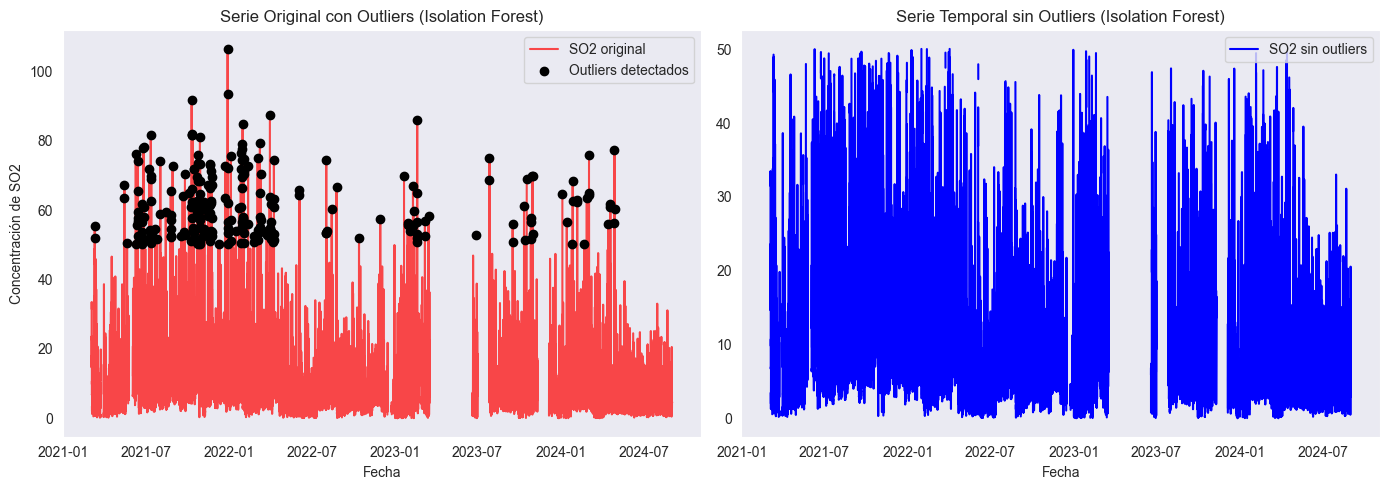

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Gráfico original con outliers resaltados
axes[0].plot(df.index, df['SO2'], label='SO2 original', color='red', alpha=0.7)
axes[0].scatter(df.loc[outliers_indices_if].index, df.loc[outliers_indices_if, 'SO2'], 
                color='black', marker='o', label='Outliers detectados', zorder=3)
axes[0].set_title("Serie Original con Outliers (Isolation Forest)")
axes[0].set_xlabel("Fecha")
axes[0].set_ylabel("Concentración de SO2")
axes[0].legend()
axes[0].grid()

# Gráfico sin outliers
df_clean_if = df.copy()
df_clean_if.loc[outliers_indices_if, 'SO2'] = np.nan  # Reemplazamos outliers con NaN (sin eliminarlos)
axes[1].plot(df_clean_if.index, df_clean_if['SO2'], label='SO2 sin outliers', color='blue')
axes[1].set_title("Serie Temporal sin Outliers (Isolation Forest)")
axes[1].set_xlabel("Fecha")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


#### Metodo autoencoders

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

# Seleccionar solo la serie de SO2 y eliminar nulos
df_so2 = df[['SO2']].dropna()

# Normalizar la serie
scaler = MinMaxScaler()
df_so2_scaled = scaler.fit_transform(df_so2)

# Función para crear ventanas de tiempo (secuencia de n pasos)
def create_sequences(data, seq_length=10):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

# Crear secuencias con 10 pasos de tiempo
seq_length = 10
X_train = create_sequences(df_so2_scaled, seq_length)

# Revisar dimensiones
print(f"Forma de los datos de entrada: {X_train.shape}")  # (muestras, pasos de tiempo, 1)


Forma de los datos de entrada: (24447, 10, 1)


## Multivariable

In [54]:
from scipy.spatial import distance, ConvexHull
from scipy.stats import kurtosis
from sklearn.covariance import EllipticEnvelope

Se usa el df filtrado

In [55]:
df = traf_filt.copy()
df = df.drop(columns=['PLiquida_SSR'])

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14617 entries, 2023-01-01 00:00:00 to 2024-09-01 00:00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DViento_SSR  14617 non-null  float64
 1   HAire10_SSR  14617 non-null  float64
 2   P_SSR        14617 non-null  float64
 3   TAire10_SSR  14617 non-null  float64
 4   VViento_SSR  14617 non-null  float64
 5   SO2          14617 non-null  float64
 6   Calidad_SO2  14617 non-null  float64
dtypes: float64(7)
memory usage: 1.4 MB


In [60]:
from numpy import average


max(df['SO2'])

85.9638484703987

In [58]:
df

,DViento_SSR,HAire10_SSR,P_SSR,TAire10_SSR,VViento_SSR,SO2,Calidad_SO2
datetime,,,,,,,
2023-01-01 00:00:00,154.220,85.382,641.094,19.688,0.474,2.336015,2.5
2023-01-01 01:00:00,149.297,84.006,640.799,19.595,0.430,2.742718,2.5
2023-01-01 02:00:00,162.696,82.637,640.338,19.258,0.309,2.963363,2.5
2023-01-01 03:00:00,155.306,79.556,640.503,19.259,0.372,2.331354,2.5
2023-01-01 04:00:00,161.778,81.358,640.537,18.513,0.206,1.977277,2.5
...,...,...,...,...,...,...,...
2024-08-31 20:00:00,185.516,68.738,640.016,24.170,0.394,4.475329,1.0
2024-08-31 21:00:00,171.754,70.792,640.401,23.668,0.505,3.652872,1.0
2024-08-31 22:00:00,185.163,70.413,640.935,23.632,0.420,3.288098,1.0


In [30]:

X = df.dropna().values

alfa = 0.01

#### FastMCD

In [31]:
envelope = EllipticEnvelope(contamination=alfa)  # Contamination is the expected proportion of outliers
envelope.fit(X)
outlier_mcd = envelope.predict(X)

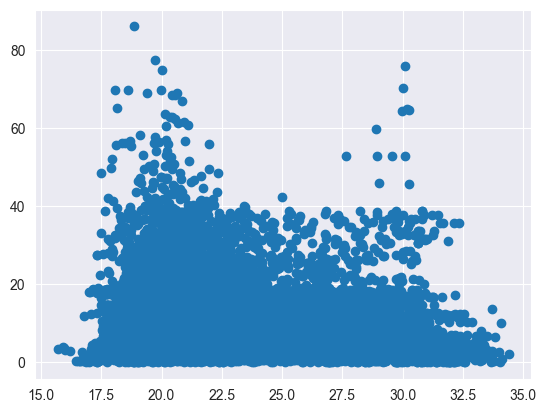

In [32]:
plt.figure('Plot X vs Y')
plt.scatter(X[:,3],X[:,5])

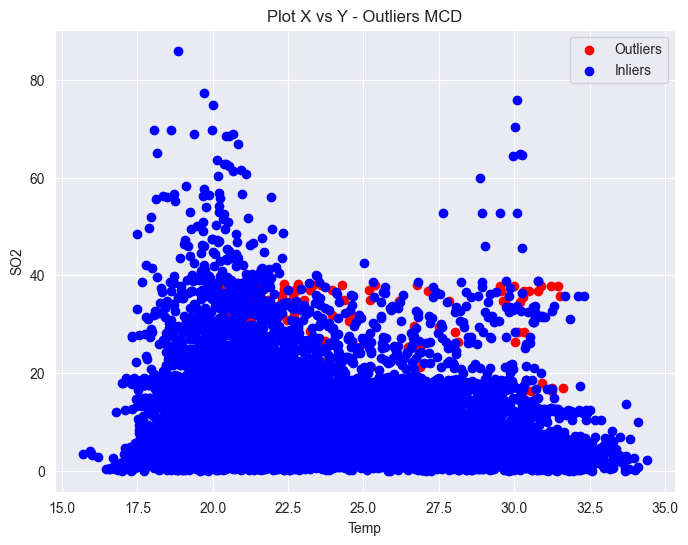

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X[outlier_mcd == -1, 3], X[outlier_mcd == -1, 5], color='red', label='Outliers')
plt.scatter(X[outlier_mcd == 1, 3], X[outlier_mcd == 1, 5], color='blue', label='Inliers')

plt.xlabel("Temp")
plt.ylabel("SO2")
plt.legend()
plt.title("Plot X vs Y - Outliers MCD")
plt.show()

#### kurtosis

In [34]:
def outliers_curtosis(matrix, alfa, num_projections = 100):
    # Generate random unit vectors as initial projections
    initial_projections = [np.random.rand(matrix.shape[1]) for _ in range(num_projections)]
    initial_projections = [v / np.linalg.norm(v) for v in initial_projections]

    # Project the data onto the initial projections
    projected_data = [np.dot(matrix, v) for v in initial_projections]

    # Calculate the kurtosis of each projection
    kurtosis_values = [kurtosis(proj) for proj in projected_data]

    # Find the projection with the highest kurtosis
    best_projection_index = np.argmax(kurtosis_values)
    best_projection = projected_data[best_projection_index]
    
    cutoff1 = np.percentile(best_projection,100-(alfa/2)*100)
    cutoff2 = np.percentile(best_projection,(alfa/2)*100)
    
    outliers = ((best_projection < cutoff2)| (best_projection > cutoff1)).astype(int)
    return outliers

In [35]:
outlier_kur = outliers_curtosis(X, alfa, num_projections = 1000)

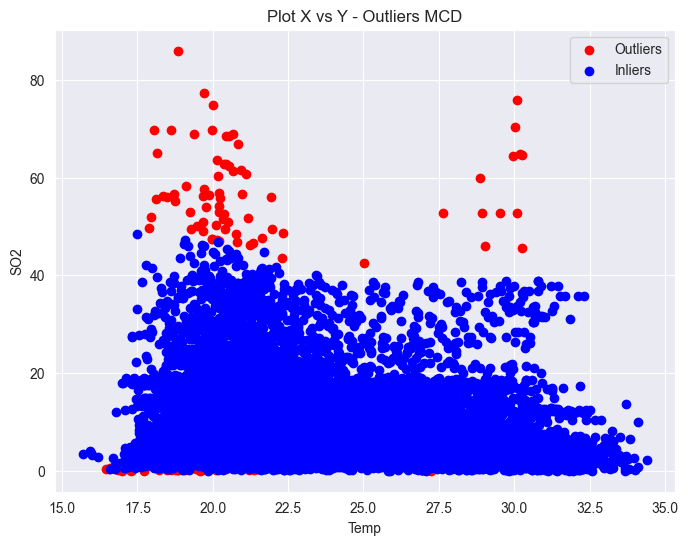

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X[outlier_kur == 1, 3], X[outlier_kur == 1, 5], color='red', label='Outliers')
plt.scatter(X[outlier_kur == 0, 3], X[outlier_kur == 0, 5], color='blue', label='Inliers')

plt.xlabel("Temp")
plt.ylabel("SO2")
plt.legend()
plt.title("Plot X vs Y - Outliers MCD")
plt.show()

In [37]:
import pandas as pd
import numpy as np

# Suponiendo que df es el DataFrame original
column_names = df.columns  # Obtener los nombres de las columnas originales

# Convertir el array a un DataFrame
df_new = pd.DataFrame(X, columns=column_names)

# Verificar el resultado
df_new['outlier_kur'] = outlier_kur
df_new[df_new['Calidad_SO2']>2.6]['outlier_kur'].value_counts()

outlier_kur
0    3529
1      26
Name: count, dtype: int64

In [38]:
df_new['outlier_kur'].value_counts()

outlier_kur
0    14469
1      148
Name: count, dtype: int64

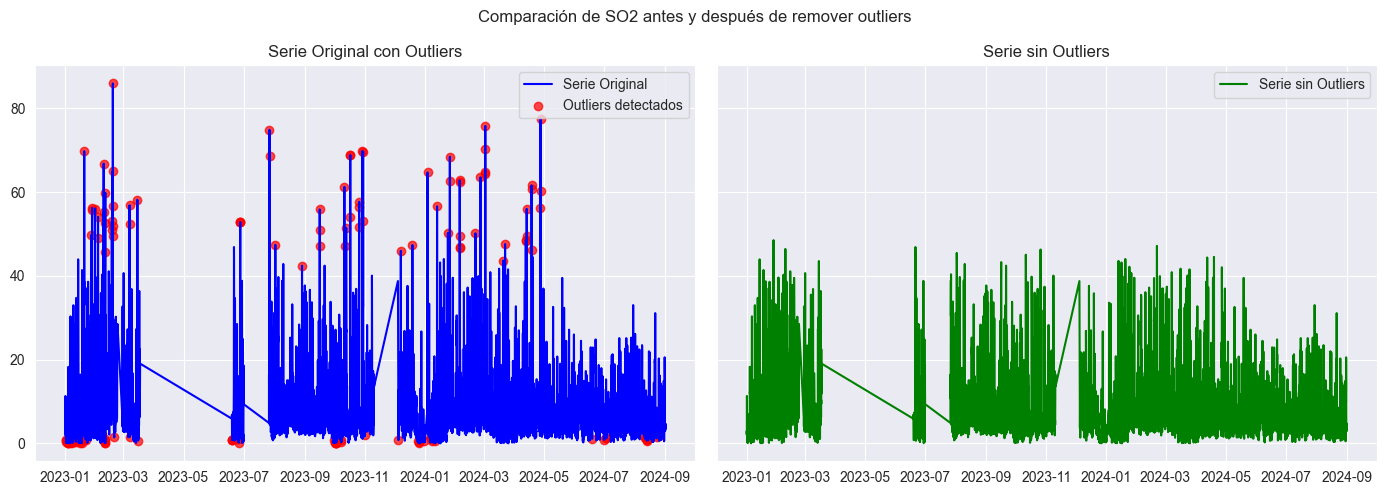

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Crear el DataFrame con los datos originales pero solo con las filas sin NaN
df_clean = df.dropna().copy()
df_clean['outlier_kur'] = outlier_kur  # Agregar columna de outliers

# Extraer la columna de SO2 con y sin outliers
so2_original = df_clean['SO2']
so2_sin_outliers = df_clean.loc[df_clean['outlier_kur'] == 0, 'SO2']

# Usar el índice de df_clean como fechas para asegurar la misma longitud
fechas = df_clean.index

# Crear la figura con subplots en una fila (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Gráfico de la serie original con outliers resaltados
axes[0].plot(fechas, so2_original, label='Serie Original', color='blue')
axes[0].scatter(fechas[df_clean['outlier_kur'] == 1], so2_original[df_clean['outlier_kur'] == 1], 
                color='red', label='Outliers detectados', alpha=0.7)
axes[0].set_title('Serie Original con Outliers')
axes[0].legend()

# Gráfico de la serie sin outliers
axes[1].plot(fechas[df_clean['outlier_kur'] == 0], so2_sin_outliers, label='Serie sin Outliers', color='green')
axes[1].set_title('Serie sin Outliers')
axes[1].legend()

# Mejorar el formato
fig.suptitle('Comparación de SO2 antes y después de remover outliers')
plt.tight_layout()
plt.show()


# eliminacion de outliers

In [40]:
fisc.replace(0, np.nan, inplace=True)

In [41]:
# Crear copias de los DataFrames
gir_imp = gir.copy()
ita_imp = ita.copy()
traf_imp = traf.copy()
fisc_imp = fisc.copy()

# Aplicar imputación sencilla (Media móvil de 3 períodos)
fisc_mean_imputed = fisc_imp.fillna(fisc_imp.rolling(window=3, min_periods=1).mean())
gir_mean_imputed = gir_imp.fillna(gir_imp.rolling(window=3, min_periods=1).mean())
ita_mean_imputed = ita_imp.fillna(ita_imp.rolling(window=3, min_periods=1).mean())
traf_mean_imputed = traf_imp.fillna(traf_imp.rolling(window=3, min_periods=1).mean())

# Aplicar imputación avanzada (Interpolación con método 'time')
fisc_interpolate_imputed = fisc_mean_imputed.interpolate(method='time')
gir_interpolate_imputed = gir_mean_imputed.interpolate(method='time')
ita_interpolate_imputed = ita_mean_imputed.interpolate(method='time')
traf_interpolate_imputed = traf_mean_imputed.interpolate(method='time')


In [42]:
import pandas as pd

# Cargar los DataFrames
fisc_imp = fisc_interpolate_imputed
gir_imp = gir_interpolate_imputed
ita_imp = ita_interpolate_imputed
traf_imp = traf_interpolate_imputed
# Lista de DataFrames originales y nombres para referencia
dfs = {'fisc': fisc_imp, 'gir': gir_imp, 'ita': ita_imp, 'traf': traf_imp}

# Crear un diccionario para guardar los DataFrames filtrados
filtered_dfs = {}

for name, df in dfs.items():
    df_copy = df.copy()
    
    # Encontrar la primera fecha con datos en 'SO2' y 'TAire10_SSR'
    first_valid_date = df_copy[['SO2', 'TAire10_SSR']].dropna().index.min()
    
    # Filtrar el DataFrame completo desde esa fecha en adelante
    df_filtered = df_copy[df_copy.index >= first_valid_date]
    
    # Guardar el DataFrame filtrado en el diccionario
    filtered_dfs[name + '_filtered'] = df_filtered
    
    # Imprimir la primera fecha válida para referencia
    print(f"Primera fecha con datos en {name}: {first_valid_date}")

Primera fecha con datos en fisc: 2023-02-24 12:00:00
Primera fecha con datos en gir: 2023-01-01 00:00:00
Primera fecha con datos en ita: 2023-05-12 23:00:00
Primera fecha con datos en traf: 2023-01-01 00:00:00


In [43]:
fisc_filt = filtered_dfs['fisc_filtered']
gir_filt = filtered_dfs['gir_filtered']
ita_filt = filtered_dfs['ita_filtered']
traf_filt = filtered_dfs['traf_filtered']

## Univariable

In [44]:
df1 = traf.copy()

In [45]:
from sklearn.ensemble import IsolationForest

# Aplicar Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_labels = iso_forest.fit_predict(df1[['SO2']].dropna())  # Solo usamos SO2 y eliminamos NaN temporalmente

# Crear un DataFrame auxiliar para recuperar los índices correctos
df_aux = df1[['SO2']].dropna().copy()
df_aux['IF_outlier'] = outlier_labels  # -1 son outliers, 1 son normales

# Crear una nueva columna en el DataFrame original
df1['IF_outlier'] = 0  # Inicializamos con 0 (no outlier)
df1.loc[df_aux[df_aux['IF_outlier'] == -1].index, 'IF_outlier'] = 1  # Marcamos con 1 los outliers

print(f"Se identificaron {df1['IF_outlier'].sum()} outliers con Isolation Forest.")

Se identificaron 241 outliers con Isolation Forest.


## multivariables

In [46]:
# Copiar el DataFrame original
df = traf_filt.copy()
df = df.drop(columns=['PLiquida_SSR'])

# Preparar los datos eliminando NaN
X = df.dropna().values

# Definir el nivel de significancia
alfa = 0.01

# Función para detectar outliers basada en curtosis proyectada
def outliers_curtosis(matrix, alfa, num_projections=100):
    # Generar vectores aleatorios unitarios como proyecciones iniciales
    initial_projections = [np.random.rand(matrix.shape[1]) for _ in range(num_projections)]
    initial_projections = [v / np.linalg.norm(v) for v in initial_projections]

    # Proyectar los datos en las proyecciones iniciales
    projected_data = [np.dot(matrix, v) for v in initial_projections]

    # Calcular la curtosis de cada proyección
    kurtosis_values = [kurtosis(proj) for proj in projected_data]

    # Encontrar la proyección con la mayor curtosis
    best_projection_index = np.argmax(kurtosis_values)
    best_projection = projected_data[best_projection_index]

    # Calcular los puntos de corte para identificar outliers
    cutoff1 = np.percentile(best_projection, 100 - (alfa / 2) * 100)
    cutoff2 = np.percentile(best_projection, (alfa / 2) * 100)

    # Identificar outliers (1 si es outlier, 0 si no lo es)
    outliers = ((best_projection < cutoff2) | (best_projection > cutoff1)).astype(int)
    return outliers

# Detectar outliers usando la función
outlier_kur = outliers_curtosis(X, alfa, num_projections=1000)

# Crear una nueva columna en el DataFrame original
df['Curtosis_outlier'] = 0  # Inicializamos con 0 (no outlier)
df.loc[df.dropna().index, 'Curtosis_outlier'] = outlier_kur  # Asignamos los valores de outliers

print(f"Se identificaron {df['Curtosis_outlier'].sum()} outliers con la técnica de curtosis proyectada.")

Se identificaron 148 outliers con la técnica de curtosis proyectada.


In [47]:
# Asegurarnos de que los índices de ambos DataFrames sean consistentes
df1 = df1.copy()  # Trabajamos con una copia de df1
df = df.copy()  # Trabajamos con una copia de df

# Agregar la columna de outliers de curtosis al df1 usando los índices
df1['Curtosis_outlier'] = 0  # Inicializamos con 0 (no outlier)
df1.loc[df.index, 'Curtosis_outlier'] = df['Curtosis_outlier']  # Asignamos los valores de df a df1

# Verificar el resultado
df1

,DViento_SSR,HAire10_SSR,PLiquida_SSR,P_SSR,TAire10_SSR,VViento_SSR,SO2,Calidad_SO2,IF_outlier,Curtosis_outlier
datetime,,,,,,,,,,
2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,0
2021-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,0
2021-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,0
2021-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,0
2021-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...
2024-08-31 20:00:00,185.516,68.738,NaN,640.016,24.170,0.394,4.475329,1.0,0,0
2024-08-31 21:00:00,171.754,70.792,NaN,640.401,23.668,0.505,3.652872,1.0,0,0
2024-08-31 22:00:00,185.163,70.413,NaN,640.935,23.632,0.420,3.288098,1.0,0,0


In [48]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32137 entries, 2021-01-01 00:00:00 to 2024-09-01 00:00:00
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DViento_SSR       14527 non-null  float64
 1   HAire10_SSR       14466 non-null  float64
 2   PLiquida_SSR      2336 non-null   float64
 3   P_SSR             14527 non-null  float64
 4   TAire10_SSR       14526 non-null  float64
 5   VViento_SSR       14527 non-null  float64
 6   SO2               24457 non-null  float64
 7   Calidad_SO2       32137 non-null  float64
 8   IF_outlier        32137 non-null  int64  
 9   Curtosis_outlier  32137 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 3.7 MB


In [49]:
# Contar el número total de outliers detectados
outliers_totales = df1[(df1['IF_outlier'] == 1)].shape[0]
outliers_totales

241

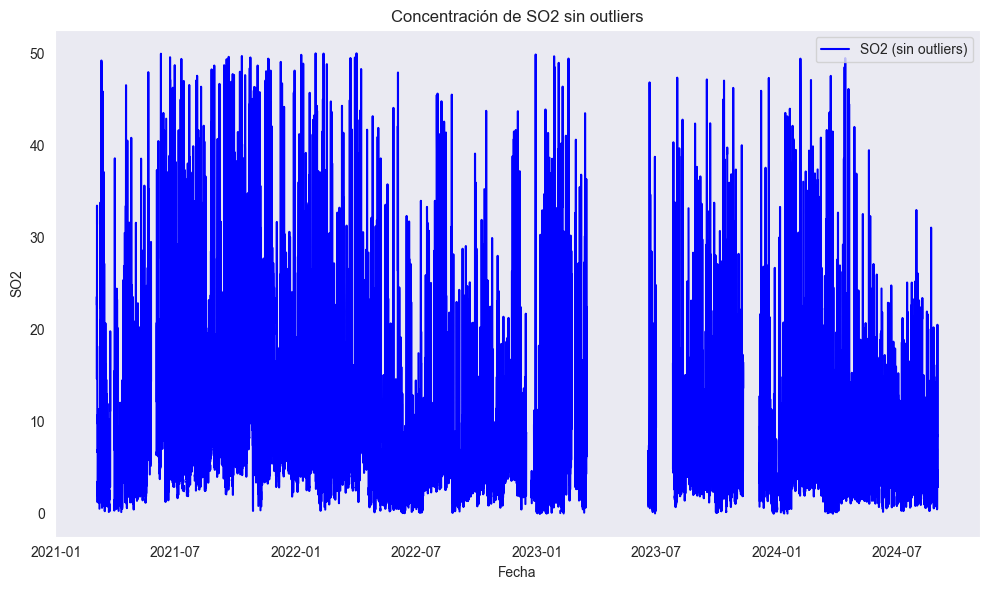

In [50]:
import matplotlib.pyplot as plt

# Crear un nuevo DataFrame eliminando los outliers univariables
df_final = df1[(df1['IF_outlier'] == 0)]

# Guardar el DataFrame final como un archivo CSV
df_final.to_csv('df_final_sin_outliers.csv', index=True)

# Graficar la columna SO2 del DataFrame final

plt.figure(figsize=(10, 6))
plt.plot(df_final.index, df_final['SO2'], label='SO2 (sin outliers)', color='blue')
plt.xlabel('Fecha')
plt.ylabel('SO2')
plt.title('Concentración de SO2 sin outliers')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('so2_sin_outliers.png')
plt.show()


In [51]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31896 entries, 2021-01-01 00:00:00 to 2024-09-01 00:00:00
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DViento_SSR       14481 non-null  float64
 1   HAire10_SSR       14423 non-null  float64
 2   PLiquida_SSR      2334 non-null   float64
 3   P_SSR             14481 non-null  float64
 4   TAire10_SSR       14480 non-null  float64
 5   VViento_SSR       14481 non-null  float64
 6   SO2               24216 non-null  float64
 7   Calidad_SO2       31896 non-null  float64
 8   IF_outlier        31896 non-null  int64  
 9   Curtosis_outlier  31896 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 2.7 MB


In [52]:
df_final.to_pickle('df_final_sin_outliers.pkl')